In [2]:
################ Code from the 'Optimization of molecular geometries' tutorial##################
# imports and relevant defines:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time

symbols = ["H", "H"]
x = np.array([0.85290734, 0.4042742 , 0.62859077, 0.66329266, 1.1119258 ,
        0.88760923], requires_grad=True)

# these parameters are used to match up with the parameters for the VQE run on water in the paper: https://arxiv.org/pdf/2106.13840.pdf
active_electrons = 2
active_orbitals = 2

# define the hamiltonian needed to compute cost-function
def H(x):
    return qchem.molecular_hamiltonian(symbols, x)[0]



################ Code from the 'Building the adaptive circuit' tutorial below:################

geometry = np.array([0.85290734, 0.4042742 , 0.62859077, 0.66329266, 1.1119258 ,
        0.88760923], requires_grad=True)
active_electrons = 2
active_orbitals = 2

H, qubits = qchem.molecular_hamiltonian(symbols, x)
singles, doubles = qchem.excitations(active_electrons, qubits)

hf_state = qchem.hf_state(active_electrons, qubits)



#compute the significant double-excitation gates:
def circuit_1(params, excitations):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(H)

dev = qml.device("default.qubit", wires=qubits)
cost_fn = qml.QNode(circuit_1, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(doubles)
grads = circuit_gradient(params, excitations=doubles)
print("Computed gradients for all possible Double Excitation Gates: \n")
for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")   
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
print("Number of selected double-excitation gates: ", len(doubles_select))



# optimizing the parameters for the double-excitation gates for Ansatz-wavefunction construction
opt = qml.GradientDescentOptimizer(stepsize=0.5)
params_doubles = np.zeros(len(doubles_select), requires_grad=True)
for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)



#compute the significant single-excitation gates:
def circuit_2(params, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)
    return qml.expval(H)


cost_fn = qml.QNode(circuit_2, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(singles)
grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select=doubles_select,
    params_select=params_doubles
)
print("\nComputed gradients for all possible Single Excitation Gates: \n")
for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
print("Number of selected single-excitation gates: ", len(singles_select))

#Total Number of Gates selected to construct the Quantum Ansatz:
print("Total selected gates: "+  str(len(doubles_select) + len(singles_select)))

################# End code from the 'Building the adaptive circuit' tutorial ##################

################ Resume from the 'Optimization of molecular geometries' tutorial below: ################
hf = hf_state


#Construct optimized parametrized circuit that will be used to run the optimized VQE algorithm
# using the selected single and double excitation gates:
num_wires = qubits
dev = qml.device("lightning.qubit", wires=num_wires)
@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    # prepares reference state
    qml.BasisState(hf, wires=wires)
    
    # apply all single excitations
    for i, singles in enumerate(singles_select):
        qml.SingleExcitation(params[i], wires=singles)
        
    # apply all double excitations
    for j, doubles in enumerate(doubles_select):
        qml.DoubleExcitation(params[j + len(singles_select)], wires=doubles)
                             
    # returns expectation value of the ansatz prepared from this quantum circuit:   
    return qml.expval(obs)

def cost(params, x):
    hamiltonian = H(x)
    return circuit(params, obs=hamiltonian, wires=range(num_wires)) 
    

# This function computes the finite-difference of the Hamiltonian itself with respect to each of the nuclear-coordinates
# itself, using a central-difference approximation.
def finite_diff(f, x, delta=0.01):
    """Compute the central-difference finite difference of a function"""
    gradient = []
    for i in range(len(x)):
        shift = np.zeros_like(x)
        shift[i] += 0.5 * delta
        res = (f(x + shift) - f(x - shift)) * delta**-1 # dH/dx            
        gradient.append(res)

    return gradient

def grad_x(params, x): #evaluate the expectation of the gradient components (each of the nuclear components of the Hamiltonian)
    grad_h = finite_diff(H, x)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    return np.array(grad)

# initialize optimizers:
opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)




# Re-initialize all relevant parameters to be optimized:
# nuclear-coordinate parameters:
symbols = ["H", "H"]
x = np.array([0.85290734, 0.4042742 , 0.62859077, 0.66329266, 1.1119258 ,
        0.88760923], requires_grad=True)

# circuit parameters:
theta = np.array([0.0] * (len(doubles_select) + len(singles_select)), requires_grad=True)

print("\nReinitialized gradient descent parameters!\n")


def H(x):
    return qchem.molecular_hamiltonian(symbols, x)[0]




# ~~~~~~~~~~~~~~ Final block: Calculating water's molecular geometry ~~~~~~~~~~~~~~~
from functools import partial

# store the values of the cost function
energy = []

# store the values of the first OH-bond length
bond_length = []

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903
start = time.time()
for n in range(100):

    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x) # compare with final block of code in 'Adapt-VQE' tutorial on Pennylane

    # Optimize the nuclear coordinates
    theta.requires_grad = False
    x.requires_grad = True
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    energy.append(cost(theta, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    if n % 4 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha,  bond length = {bond_length[-1]:.5f} Å")

    # Check maximum component of the nuclear gradient
    if np.max(grad_x(theta, x)) <= 1e-05:
        break
end = time.time()

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")
    
print("")
print("Total time:", end-start, "seconds")

Computed gradients for all possible Double Excitation Gates: 

Excitation : [0, 1, 2, 3], Gradient: -0.16497372126963
Number of selected double-excitation gates:  1

Computed gradients for all possible Single Excitation Gates: 

Excitation : [0, 2], Gradient: 0.0
Excitation : [1, 3], Gradient: 0.0
Number of selected single-excitation gates:  0
Total selected gates: 1

Reinitialized gradient descent parameters!

Step = 0,  E = -1.00521996 Ha,  bond length = 1.24090 Å
Step = 4,  E = -1.13442345 Ha,  bond length = 0.79676 Å
Step = 8,  E = -1.13727238 Ha,  bond length = 0.73693 Å
Step = 12,  E = -1.13730408 Ha,  bond length = 0.73532 Å
Step = 16,  E = -1.13730594 Ha,  bond length = 0.73498 Å

Final value of the ground-state energy = -1.13730594 Ha

Ground-state equilibrium geometry
symbol    x        y        z
  H    0.9275   0.1257   0.5267
  H    0.5887   1.3905   0.9895

Total time: 37.08103013038635 seconds


In [5]:
bond_length[-1]

0.7349774005718944

In [7]:
len(bond_length)

17

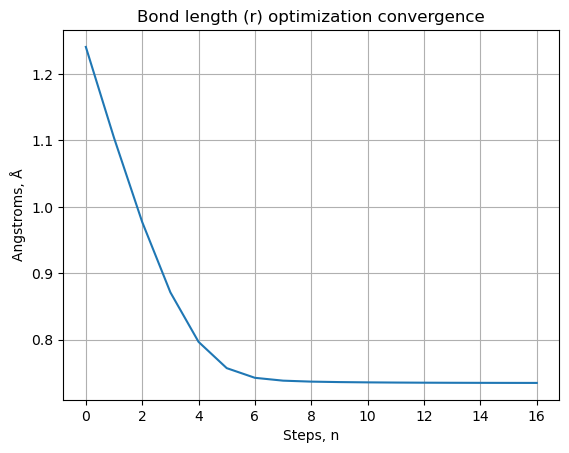

In [4]:
import matplotlib.pyplot as plt
np_bl = np.array(bond_length)
np_en = np.array(energy)
plt.plot(np_bl)

plt.axhline(y=0.7414, color='r', linestyle='--')
plt.text(15, 0.76, 'Accepted value', horizontalalignment='right')

plt.xlabel("Steps, n")
plt.ylabel("Angstroms, Å")
plt.title("Bond length (r) optimization convergence")
plt.grid(True)

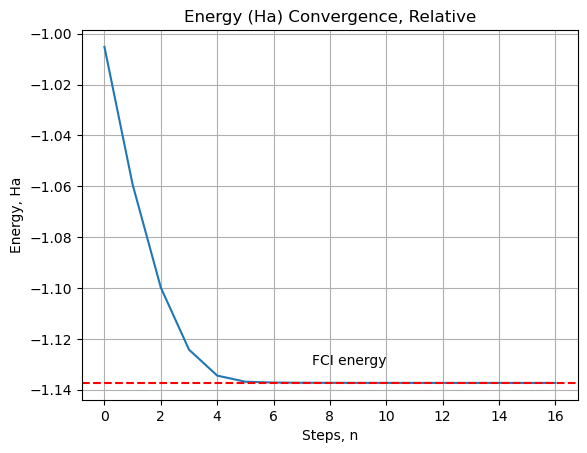

In [7]:
plt.plot(energy)
plt.xlabel("Steps, n")
plt.ylabel("Energy, Ha")

plt.axhline(y=-1.1372633205048763, color='r', linestyle='--')
plt.text(10, -1.13, 'FCI energy', horizontalalignment='right')

plt.title("Energy (Ha) Convergence, Relative")
plt.grid(True)